[View in Colaboratory](https://colab.research.google.com/github/planewave/coherent_receiver_with_CNN/blob/master/equalization.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt

In [0]:
#@title
def rrcosdesign(beta, span, sps):
    """
    returns the coefficients, that correspond to a square-root raised 
    cosine FIR filter with rolloff factor specified by beta. The filter 
    is truncated to span symbols, and each symbol period contains sps 
    samples. The order of the filter, sps*span, must be even. 
    modified from:
    https://github.com/veeresht/CommPy/blob/master/commpy/filters.py
    """
    n = sps*span
    rrc = np.zeros(n, dtype=float)
        
    for x in np.arange(n):
        t = (x-n/2)/sps
        if t == 0.0:
            rrc[x] = 1.0 - beta + (4*beta/np.pi)
        elif beta != 0 and t == 1/(4*beta):
            rrc[x] = ((beta/np.sqrt(2))*(((1+2/np.pi)*(np.sin(np.pi/
                     (4*beta)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*beta))))))
        elif beta != 0 and t == -1/(4*beta):
            rrc[x] = ((beta/np.sqrt(2))*(((1+2/np.pi)*(np.sin(np.pi/
                     (4*beta)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*beta))))))
        else:
            rrc[x] = ((np.sin(np.pi*t*(1-beta))+4*beta*(t)*np.cos(np.pi*
                     t*(1+beta)))/(np.pi*t*(1-(4*beta*t)*(4*beta*t))))
        
    return rrc

def demod_qpsk(sig):
    """
    demodulation of QPSK signal
    complex 1D array input
    soft max decision output
    """
    out = np.zeros((sig.size, 4))
    x = sig.real
    y = sig.imag
    out[:, 0] = y*(x>y)+x*(x<=y)
    out[:, 1] = y*(-x>y)-x*(-x<=y)
    out[:, 2] = -y*(-x>-y)-x*(-x<=-y)
    out[:, 3] = -y*(x>-y)+x*(x<=-y)
    e_x = np.exp(out-out.max(axis = 1).reshape(-1,1))
    soft_dc = e_x/e_x.sum(axis = 1).reshape(-1,1)
    hard_dc = np.argmax(soft_dc, axis=1)
    return hard_dc, soft_dc

def upsample(x, n):
    """
    increase sample rate by integer factor
    y = upsample(x,n) increases the sample rate of x by 
    inserting n – 1 zeros between samples.
    input is 1D numpy array
    
    """
    zo = np.zeros((len(x), n), dtype=x.dtype)
    zo[:,0] += x
    return zo.flatten()

In [0]:
M = 4
SYMB = 100 # num of symbols
msg = np.random.randint(0, M, SYMB)
sig_mod = np.exp(1j*(np.pi/M+msg*(2*np.pi/M)))
# pluse shaping 
beta = 0.4
span = 8
sps = 16
rrc = rrcosdesign(beta, span, sps)
sig_up = upsample(sig_mod, sps)
sig_pulse = np.convolve(sig_up, rrc)
# plt.plot(sig_pulse.real)
# plt.plot(sig_pulse.imag)
# plt.show()


# up convert
fc = 7.1e3
baud = 1e3
fs = baud*sps # 24kHz
samp_len = len(sig_pulse)
time = np.arange(samp_len)/fs
carrier = np.exp(1j*(2*np.pi*fc*time))
sig_pass = np.real(sig_pulse*carrier)

In [0]:
# channel
hp = np.zeros(5*32) # 5 ms
hp[0], hp[38], hp[90], hp[127] = 1, 0.7, 0.4, 0.3
sig_ch = np.convolve(sig_pass, hp)[0:sig_pass.size]+ \
        0.5*np.random.randn(sig_pass.size)
# plt.plot(hp)
# plt.show()

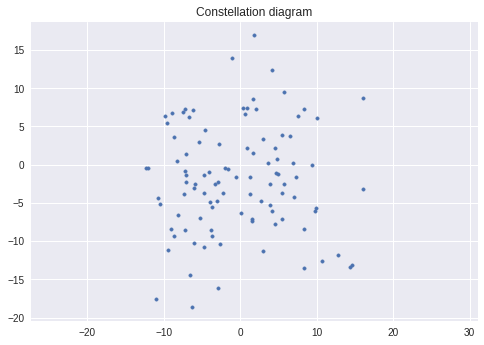

0.8

In [5]:
# receiver side
# down convert to baseband
sig_base = sig_ch*np.conj(carrier)
# sig_filt = sig.upfirdn(rrc, sig_base)
# sig_dn = sig.upfirdn(rrc, sig_base, 1, sps)[span:-span]

sig_filt = np.convolve(sig_base, rrc)
sig_timing = sig_filt[span*sps:-span*sps:sps]


plt.scatter(sig_timing.real, sig_timing.imag, marker='.')
plt.axis('equal')
plt.title('Constellation diagram')
# plt.ylim(-20, 20)
# plt.xlim(-20, 20)
plt.show()

# deodulation
demod  = demod_qpsk(sig_timing)[0]
symb_err = np.sum(msg == demod)/SYMB
symb_err
# print(msg, demod)

In [6]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip -q install http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5e09e000 @  0x7f4e2baba1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [7]:
from torch import nn
device = torch.device("cuda:0")
dtype = torch.float
LR = 1e-3 # learning rate

rec = np.zeros((SYMB, 2, 32))
for symb_ind in range(SYMB):
    rec[symb_ind, 0, :] = sig_base[symb_ind: symb_ind+32].real
    rec[symb_ind, 1, :] = sig_base[symb_ind: symb_ind+32].imag
# symb_in_cplx = sig_base[symb_ind: symb_ind+32]
# symb_in = np.array([symb_in_cplx.real, symb_in_cplx.imag])
rec = torch.tensor(rec, device=device, dtype=dtype)
rec.shape

torch.Size([100, 2, 32])

In [0]:
# cnn = nn.Sequential(
#     nn.Conv1d(2, 64, 5),
#     nn.ReLU(),
#     nn.MaxPool1d(2),
#     nn.Conv1d(64, 32, 3),
#     nn.ReLU(),
#     nn.MaxPool1d(2),
#     nn.Conv1d(32, 16, 3),
#     nn.ReLU(),
# )
# lin = nn.Linear(16*4, 2)

# cnn.cuda()
# lin.cuda()
# cnn(rec).size()
# lin(cnn(rec).view(1, -1)).shape

In [0]:
class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 16, 3),
            nn.ReLU(),
#             nn.MaxPool1d(2),
#             nn.Conv1d(8, 8, 3),
#             nn.ReLU(),
            )

        self.lin = nn.Linear(16*4, 2)

    def forward(self, x_in):
        cnn_out = self.cnn(x_in)
        lin_out = self.lin(cnn_out.view(cnn_out.size(0), -1))
        return lin_out

net = NET()
net.cuda()
    
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()
target = torch.tensor(msg, device=device, dtype=torch.long)


In [30]:

for epoch in range(100):
    net_out = net(rec)
    x = net_out[:, 0]
    y = net_out[:, 1]

    est = torch.zeros(SYMB, M, device=device, dtype=dtype)
    est[:, 0] = y*(x>y).float()+x*(x<=y).float()
    est[:, 1] = y*(-x>y).float()-x*(-x<=y).float()
    est[:, 2] = -y*(-x>-y).float()-x*(-x<=-y).float()
    est[:, 3] = -y*(x>-y).float()+x*(x<=-y).float()

    loss = loss_func(est, target)
    optimizer.zero_grad()                           # clear gradients for this training step
    loss.backward()                                 # backpropagation, compute gradients
    optimizer.step()
    if epoch%10 == 0:
        prediction = torch.max(nn.functional.softmax(est, 1), 1)[1]
        accu = torch.sum(prediction == target).item()/prediction.size(0)
        print('Epoch:', epoch, 'accuracy:', accu)
# 


Epoch: 0 accuracy: 1.0
Epoch: 10 accuracy: 1.0
Epoch: 20 accuracy: 1.0
Epoch: 30 accuracy: 1.0
Epoch: 40 accuracy: 1.0
Epoch: 50 accuracy: 1.0
Epoch: 60 accuracy: 1.0
Epoch: 70 accuracy: 1.0
Epoch: 80 accuracy: 1.0
Epoch: 90 accuracy: 1.0


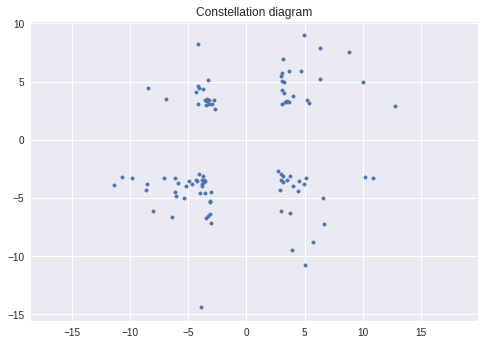

In [31]:
plt.scatter(x.detach().cpu().numpy(), y.detach().cpu().numpy(), marker='.')
plt.axis('equal')
plt.title('Constellation diagram')
# plt.ylim(-20, 20)
# plt.xlim(-20, 20)
plt.show()